Abhishek and I worked on the same system, and I combined our work and pushed the code to GitHub.

| Student Name | Contribution |
| -- | -- |
| Abhishek Pandey (500227770) | Model 2 building and tuning |
| Ram Krishna Dhakal (500228601) | Model 1 building and tuning |

Model1: Generated image samples

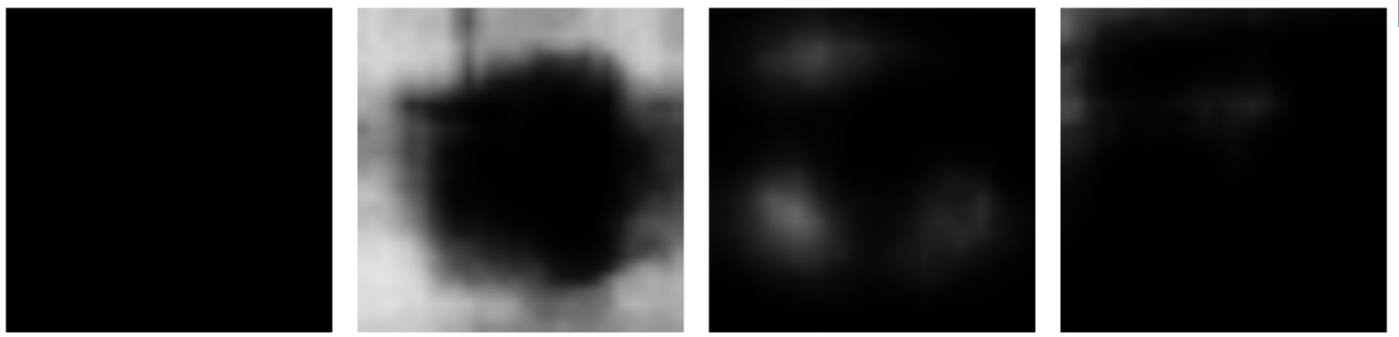

Inception Score: 1.0977177619934082 ± 0.003329051425680518

FID Score: 103.6321131421275

Generated images after tuning 1

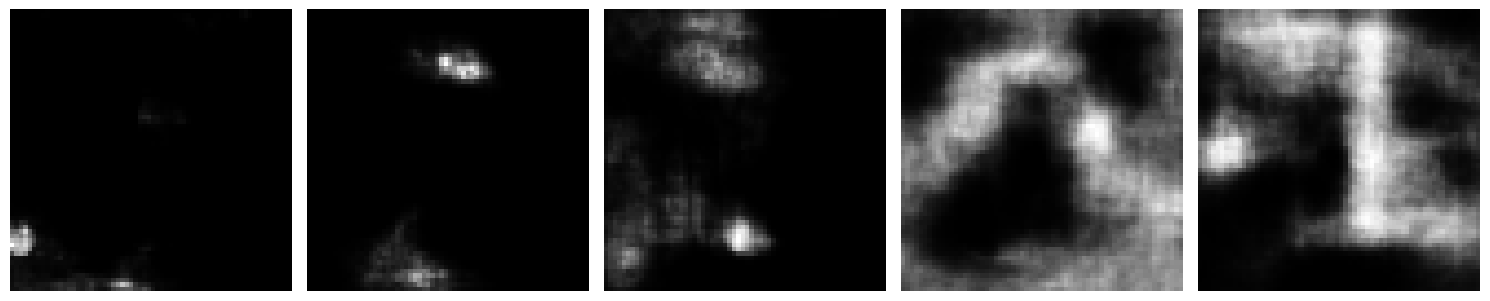

Inception Score: 1.04 ± 0.00

FID Score: 31356426390489258947804191927958219893703036961285093488599847413493086196522253235332284905802499620864.00

Model 2: with convolution layers in the encoder and decoder
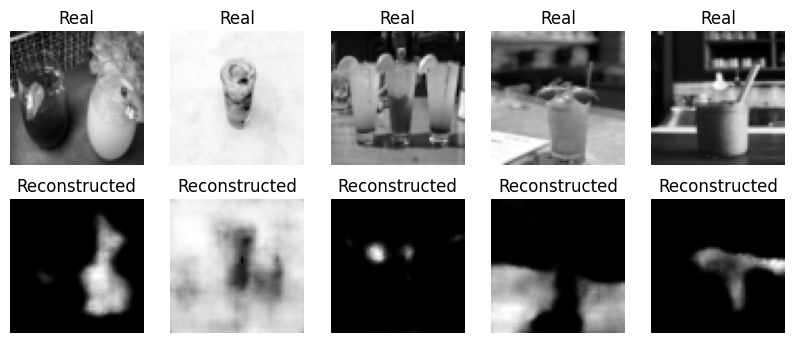

Inception Score: 1.04 ± 0.00

FID Score: -4271974071841820164790043412339104229205409044713305539894083215644439451561281100045924173873152.00

Model2: tuning (with encoder features)

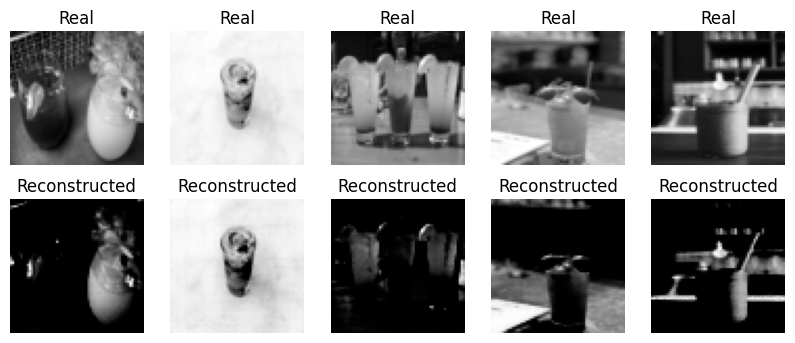

Inception Score: 1.00 ± 0.00

FID Score: 559936185544451052639360570142111069530411374308662383724997275240947967795040236345219373317901778944.00


# Model 1

## Key Details:
- **Input Dimensions:** 28 × 28 (images flattened to 784)  
- **Latent Dimensionality:** 20  
- **Training Epochs:** 10  
- **Loss Function:** Standard VAE loss  
  - Combination of:
    - Reconstruction Loss (Binary Cross-Entropy)
    - Kullback-Leibler (KL) Divergence


In [312]:
import os
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn.functional as F

In [313]:
# Custom Dataset for Flat Folder Structure
class FlatImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))  # Accept common image formats
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  #(all images belong to one class)


# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),                 # Resize to 28x28 for compatibility with FC layers
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [314]:
# Encoder with Fully Connected Layers
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
# Decoder with Fully Connected Layers
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat
    

In [315]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [316]:
# Loss Function
def loss_function(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction="sum")  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
    return recon_loss + kl_divergence

In [317]:
# Hyperparameters
input_dim = 28 * 28  # Flattened input image dimensions (28x28)
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 64
epochs = 10

# Dataset and DataLoader
dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model and Optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Training Loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for images, _ in dataloader:
        images = images.view(-1, input_dim)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(images)
        loss = loss_function(images, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(vae.state_dict(), "models/main_vae_model.pth")

Epoch 1, Loss: 206.4068
Epoch 2, Loss: 186.8069
Epoch 3, Loss: 182.1036
Epoch 4, Loss: 179.6335
Epoch 5, Loss: 177.5189
Epoch 6, Loss: 175.9467
Epoch 7, Loss: 174.9748
Epoch 8, Loss: 174.2002
Epoch 9, Loss: 173.7661
Epoch 10, Loss: 173.2877


In [331]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn

In [332]:
# Load Pretrained InceptionV3 model
def load_inception_model(device):
    inception = models.inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity() 
    inception.to(device)
    inception.eval()
    return inception

In [333]:
# Compute Inception Score
def compute_inception_score(images, inception, device, splits=10):
    images = images.to(device)
    with torch.no_grad():
        preds = torch.softmax(inception(images), dim=1).cpu().numpy()
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

In [334]:
# Compute Frechet Inception Distance (FID)
def compute_fid(real_activations, fake_activations):
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [338]:
def evaluate_saved_vae(model_path, dataloader, latent_dim, device, num_samples=5):
    # Initialize the VAE model
    input_dim = 28 * 28 
    hidden_dim = 400
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)

    # Load the saved state dictionary
    vae.load_state_dict(torch.load(model_path, map_location=device))
    vae.eval()

    generated_images = []
    real_images = []

    for images, _ in dataloader:
        images = images.view(images.size(0), -1).to(device)
        real_images.append(images)
        with torch.no_grad():
            z = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = vae.decoder(z).cpu()
            generated_images.append(fake_images)

    real_images = torch.cat(real_images, dim=0)
    generated_images = torch.cat(generated_images, dim=0)

    # Normalize, reshape, and resize for InceptionV3
    real_images = real_images.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)  # Grayscale to RGB
    real_images = F.interpolate(real_images, size=(75, 75), mode="bilinear")  # Resize to 75x75

    generated_images = generated_images.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
    generated_images = F.interpolate(generated_images, size=(75, 75), mode="bilinear")

    # Load InceptionV3
    inception = load_inception_model(device)

    # Real and Fake activations
    real_activations = []
    fake_activations = []
    with torch.no_grad():
        for imgs in torch.split(real_images, 64):
            real_activations.append(inception(imgs).cpu().numpy())
        for imgs in torch.split(generated_images, 64):
            fake_activations.append(inception(imgs).cpu().numpy())

    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)

    # Calculate IS and FID
    inception_score, inception_std = compute_inception_score(generated_images, inception, device)
    fid_score = compute_fid(real_activations, fake_activations)

    print(f"Inception Score: {inception_score} ± {inception_std}")
    print(f"FID Score: {fid_score}")

    # Return generated images for visualization
    return generated_images.cpu()

# Display Generated Images
def display_images(images, num_images=16):
    images = images[:num_images]  # Select the first `num_images`
    if images.size(1) == 1:  # Grayscale
        images = images.view(-1, 28, 28).cpu().numpy()
    else:  # RGB
        images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to [H, W, C]
    
    plt.figure(figsize=(8, 8))
    for i, img in enumerate(images):
        plt.subplot(4, 4, i + 1)
        if len(img.shape) == 2:  # Grayscale
            plt.imshow(img, cmap="gray")
        else:  # RGB
            plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\1762133260.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path, map_location=devi

Inception Score: 1.0977177619934082 ± 0.003329051425680518
FID Score: 103.6321131421275


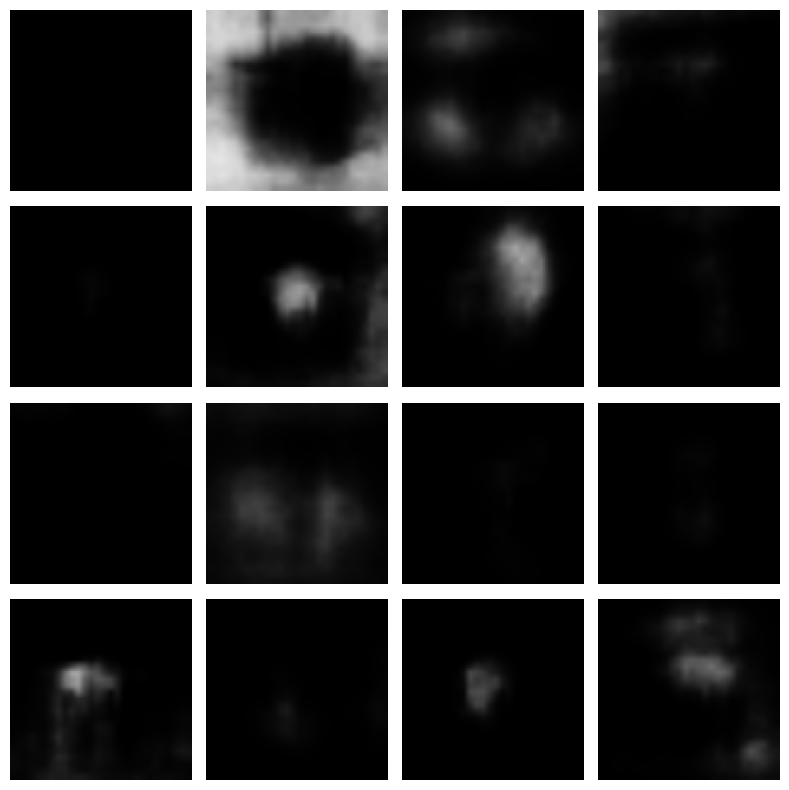

In [339]:
latent_dim = 20
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "models/main_vae_model.pth"  # Path to your saved VAE model

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])
dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Evaluate and Generate Images
generated_images = evaluate_saved_vae(model_path, dataloader, latent_dim, device)

# Display Generated Images
display_images(generated_images)


# Model 1: Tuning 1

## Key Changes:
- **Input Dimensions:** 64x64  
- **Latent Dimensionality:** 128  
- **Training Epochs:** 50  
- **Loss Function:** Standard VAE Loss  
- **Augmented Transformations:** Resize to 64x64  


In [342]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import inception_v3
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [343]:
# --- Dataset Definition ---
class FlatImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label

In [344]:
# --- VAE Definition ---
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [345]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

In [346]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [347]:
# --- Loss Function ---
def loss_function(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [348]:

# --- Data Preprocessing ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- Model Training ---
input_dim = 64 * 64  # Flattened input size
hidden_dim = 400
latent_dim = 128
lr = 1e-3
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in dataloader:
        x = x.view(-1, input_dim).to(device)  # Flatten the image
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

# Save the trained model
torch.save(vae.state_dict(), "models/main2_vae_model.pth")

Epoch 1, Loss: 1147.1744513301692
Epoch 2, Loss: 1049.2895583220325
Epoch 3, Loss: 1018.8970941189375
Epoch 4, Loss: 998.2435647834237
Epoch 5, Loss: 984.4181833818602
Epoch 6, Loss: 974.32676142709
Epoch 7, Loss: 967.0151503669432
Epoch 8, Loss: 959.94550419791
Epoch 9, Loss: 955.3932870832003
Epoch 10, Loss: 950.7847055480217
Epoch 11, Loss: 947.7086670389278
Epoch 12, Loss: 944.5420469049138
Epoch 13, Loss: 941.4093657765635
Epoch 14, Loss: 939.2906013182036
Epoch 15, Loss: 937.8005942884492
Epoch 16, Loss: 935.4924003868857
Epoch 17, Loss: 934.3980331644863
Epoch 18, Loss: 932.5079351467773
Epoch 19, Loss: 931.3049828992501
Epoch 20, Loss: 930.2436443044033
Epoch 21, Loss: 928.8430993738034
Epoch 22, Loss: 928.2733854000479
Epoch 23, Loss: 927.5800345006381
Epoch 24, Loss: 926.5153640016752
Epoch 25, Loss: 925.718131032626
Epoch 26, Loss: 924.8431669292438
Epoch 27, Loss: 924.6535507737715
Epoch 28, Loss: 923.730501655233
Epoch 29, Loss: 922.9537090678845
Epoch 30, Loss: 922.595491

In [349]:
# --- Evaluation Functions ---
def load_inception_model():
    model = inception_v3(pretrained=True, transform_input=False)
    model.fc = nn.Identity()  # Remove classification head
    model.eval()
    return model

In [350]:
def preprocess_for_inception(images):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return torch.stack([transform(img) for img in images])


In [351]:
def compute_inception_score(images, inception_model):
    images = preprocess_for_inception(images)
    with torch.no_grad():
        preds = F.softmax(inception_model(images), dim=1).cpu().numpy()
    split_scores = []
    for i in range(10):  # Split into 10 batches
        part = preds[i * len(preds) // 10:(i + 1) * len(preds) // 10]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

In [352]:
def compute_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)

In [356]:
def evaluate_saved_vae(model_path, dataloader, latent_dim, num_samples=16):
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    # Generate fake images
    z = torch.randn(num_samples, latent_dim).to(device)
    fake_images = vae.decoder(z).view(-1, 1, 64, 64)  # Reshape to image format

    # Real images
    real_images = []
    for x, _ in dataloader:
        real_images.extend(x)
        if len(real_images) >= num_samples:
            break

    # Load Inception model
    inception = load_inception_model().to(device)

    # Compute metrics
    real_features = inception(preprocess_for_inception(real_images).to(device)).cpu().detach().numpy()
    fake_features = inception(preprocess_for_inception(fake_images).to(device)).cpu().detach().numpy()

    is_mean, is_std = compute_inception_score(fake_images, inception)
    fid = compute_fid(real_features, fake_features)

    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
    print(f"FID Score: {fid:.2f}")
    return fake_images

In [361]:
# --- Display Images ---
def display_images(images, num_images=5):
    images = images[:num_images].detach().cpu().numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\4069874980.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


Inception Score: 1.04 ± 0.00
FID Score: 31356426390489258947804191927958219893703036961285093488599847413493086196522253235332284905802499620864.00


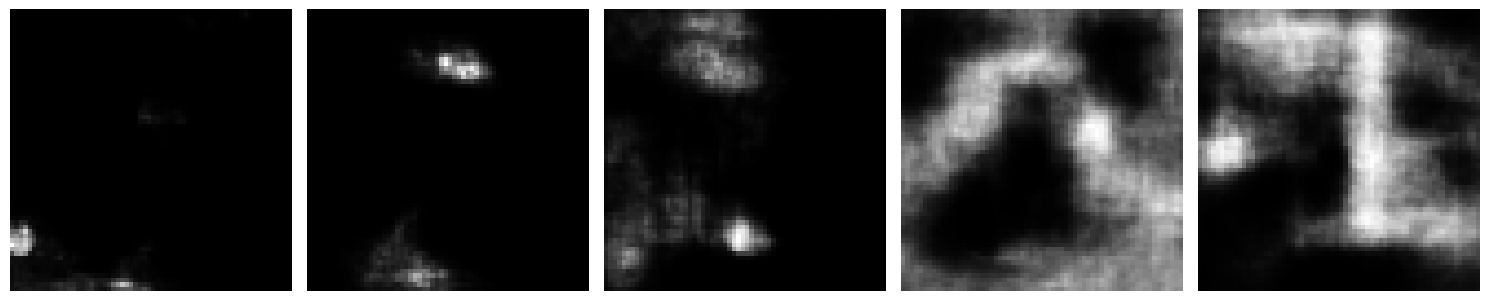

In [362]:
# --- Main Evaluation ---
model_path = "models/main2_vae_model.pth"
generated_images = evaluate_saved_vae(model_path, dataloader, latent_dim, num_samples=64)
display_images(generated_images)

# Model 2: Variational Autoencoder (VAE)

## Description:
In this model, we implemented a **Variational Autoencoder (VAE)**. Both the encoder and decoder use convolutional layers, and the model includes additional regularization through the KL divergence term.

## Key Details:
- **Latent Dimensionality:** 64  
- **β (Beta):** 1 (standard VAE regularization)  
- **Architecture:** Fewer convolutional layers in both encoder and decoder  



In [389]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x16x16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x8x8
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1) 
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [390]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x16x16
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x32x32
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)  # Output: 1x64x64

    def forward(self, z):
        x = torch.relu(self.fc(z)).view(-1, 128, 8, 8)
        x = torch.relu(self.deconv1(x))
        x = torch.relu(self.deconv2(x))
        # Use sigmoid to map to [0, 1]
        x = torch.sigmoid(self.deconv3(x))  
        return x

In [391]:

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [392]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    Compute the VAE loss: Reconstruction Loss + beta * KL Divergence.
    """
    reconstruction_loss = nn.MSELoss()(recon_x, x)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld_loss /= x.size(0) * x.size(1) * x.size(2) * x.size(3)  # Normalize by batch and image size
    return reconstruction_loss + beta * kld_loss


In [393]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# Data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [394]:
# Load dataset
dataset = FlatImageFolder(root="drink", transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [401]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False, save_path="vae_best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss  
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased. Saving model to {self.save_path}")
        torch.save(model.state_dict(), self.save_path)


In [402]:
# Initialize model and optimizer
vae = VAE(latent_dim=64).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Early stopping setup
early_stopping = EarlyStopping(patience=10, verbose=True, save_path="vae_best_model.pth")

In [403]:

# Training loop
vae.train()
epochs = 50
for epoch in range(epochs):
    # Training phase
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    val_loss = 0
    vae.eval()
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            recon_images, mu, logvar = vae(images)
            loss = vae_loss_function(recon_images, images, mu, logvar)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    # Print progress
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Early stopping
    early_stopping(avg_val_loss, vae)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 0.290988, Val Loss: 0.254831
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 2, Train Loss: 0.247294, Val Loss: 0.238218
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 3, Train Loss: 0.236712, Val Loss: 0.232361
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 4, Train Loss: 0.232583, Val Loss: 0.230052
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 5, Train Loss: 0.230217, Val Loss: 0.227774
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 6, Train Loss: 0.228385, Val Loss: 0.226293
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 7, Train Loss: 0.227054, Val Loss: 0.225009
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 8, Train Loss: 0.225856, Val Loss: 0.224014
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 9, Train Loss: 0.225074, Val Loss: 0.223540
Validation loss decreased. Saving model to vae_best_mo

In [416]:
# Load the best model for evaluation
vae.load_state_dict(torch.load("vae_best_model.pth"))
vae.eval()

# Generate reconstructed images for comparison
with torch.no_grad():
    # Get 5 real images
    real_images, _ = next(iter(val_loader))
    real_images = real_images[5:].to(device)

    # Reconstruct the real images
    mu, logvar = vae.encoder(real_images)  # Only two outputs: mu and logvar
    z = vae.reparameterize(mu, logvar)  # Encode to latent space
    reconstructed_images = vae.decoder(z).cpu()  # Decode to image space

    # Move real images to CPU for visualization
    real_images = real_images.cpu()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\442000025.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_best_model.pth"))


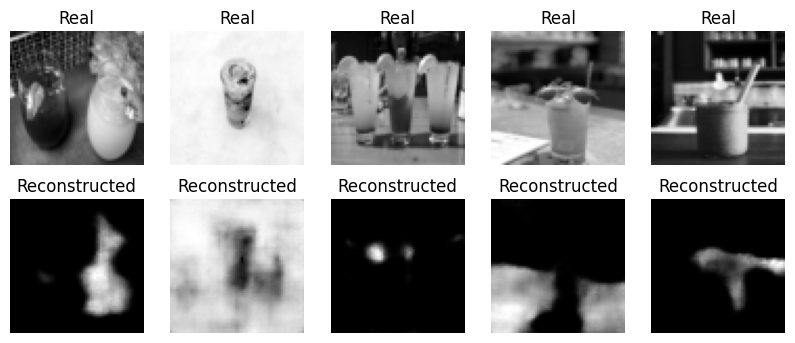

In [417]:

# Visualization
import matplotlib.pyplot as plt

def visualize_images(real_images, reconstructed_images):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Real images
        plt.subplot(2, 5, i + 1)
        plt.imshow(real_images[i].squeeze(), cmap="gray")
        plt.title("Real")
        plt.axis("off")

        # Reconstructed images
        plt.subplot(2, 5, i + 1 + 5)
        plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

visualize_images(real_images, reconstructed_images)

#### Calculation of Fréchet Inception Distance (FID) and Inception Score (IS)


In [419]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision import transforms
from scipy.linalg import sqrtm
import numpy as np

# Preprocessing for InceptionV3
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [420]:
def compute_inception_features(images, model, batch_size=32):
    """
    Computes features using the InceptionV3 model.
    Args:
        images (Tensor): Input images.
        model (torch.nn.Module): Pretrained InceptionV3 model.
        batch_size (int): Batch size for processing.
    Returns:
        features (ndarray): Inception features.
    """
    features = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            batch_features = model(batch).cpu().numpy()
            features.append(batch_features)
    return np.concatenate(features, axis=0)


def compute_inception_score(preds, splits=10):
    """
    Computes the Inception Score (IS).
    Args:
        preds (ndarray): Softmax predictions from InceptionV3.
        splits (int): Number of splits for IS calculation.
    Returns:
        mean_score (float): Mean IS.
        std_score (float): Standard deviation of IS.
    """
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

In [421]:


def compute_fid(real_features, fake_features):
    """
    Computes the Frechet Inception Distance (FID).
    Args:
        real_features (ndarray): Features of real images.
        fake_features (ndarray): Features of generated images.
    Returns:
        fid (float): FID score.
    """
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)


In [422]:
# Load the pretrained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = nn.Identity()  # Remove the classification head
inception_model.to(device)
inception_model.eval()

# Prepare data
with torch.no_grad():
    # Preprocess real images
    real_images, _ = next(iter(val_loader))  # Use a batch from the validation loader
    real_images = real_images[:500]  
    real_images = torch.stack([preprocess(img) for img in real_images]).to(device)

    # Generate fake images
    z = torch.randn(len(real_images), 64).to(device) 
    generated_images = vae.decoder(z)
    generated_images = torch.stack([preprocess(img) for img in generated_images]).to(device)

# Compute features
real_features = compute_inception_features(real_images, inception_model)
fake_features = compute_inception_features(generated_images, inception_model)

In [423]:
# Compute Inception Score
with torch.no_grad():
    preds = F.softmax(inception_model(generated_images), dim=1).cpu().numpy()
inception_score_mean, inception_score_std = compute_inception_score(preds)

# Compute FID
fid_score = compute_fid(real_features, fake_features)

print(f"Inception Score: {inception_score_mean:.2f} ± {inception_score_std:.2f}")
print(f"FID Score: {fid_score:.2f}")

Inception Score: 1.04 ± 0.00
FID Score: -4271974071841820164790043412339104229205409044713305539894083215644439451561281100045924173873152.00


# Model 2: Tuning

## Key Changes:
- **Latent Dimensionality:** 128  
- **Included Encoder Features:** Yes  
- **β (Beta):** 4 (for β-VAE, controlling KL divergence weight)  
- **Architecture:** Added convolution layers with skip connections  



In [459]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # Output: 512x4x4
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x1 = torch.relu(self.conv1(x))  
        x2 = torch.relu(self.conv2(x1)) 
        x3 = torch.relu(self.conv3(x2)) 
        x4 = torch.relu(self.conv4(x3)) 
        x_flat = x4.view(x4.size(0), -1)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        return mu, logvar, [x1, x2, x3]  # Return intermediate feature maps


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, z, encoder_features):
        x = self.fc(z).view(-1, 512, 4, 4)
        x = torch.relu(self.deconv1(x))
        x = x + encoder_features[2]  
        x = torch.relu(self.deconv2(x))
        x = x + encoder_features[1]  
        x = torch.relu(self.deconv3(x))
        x = x + encoder_features[0]  
        x = torch.sigmoid(self.deconv4(x))  
        return x


In [460]:
# Variational Autoencoder (VAE) with Skip Connections
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar, encoder_features = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, encoder_features)
        return x_hat, mu, logvar

In [461]:
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss with a beta parameter for KL divergence.
    """
    reconstruction_loss = nn.MSELoss()(recon_x, x)  # MSE for continuous data
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    kld_loss /= x.size(0) * x.size(1) * x.size(2) * x.size(3)  # Normalize
    return reconstruction_loss + beta * kld_loss

In [465]:
vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=2, verbose=True, save_path="vae_best_model.pth")

epochs = 15
beta = 4.0  # Beta for KL divergence regularization

for epoch in range(epochs):
    # Training phase
    vae.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss_function(recon_images, images, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            recon_images, mu, logvar = vae(images)
            loss = vae_loss_function(recon_images, images, mu, logvar, beta)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    # Print progress
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    early_stopping(avg_val_loss, vae)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 0.209481, Val Loss: 0.190842
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 2, Train Loss: 0.191670, Val Loss: 0.188641
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 3, Train Loss: 0.190434, Val Loss: 0.188044
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 4, Train Loss: 0.189914, Val Loss: 0.187635
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 5, Train Loss: 0.189682, Val Loss: 0.187420
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 6, Train Loss: 0.189505, Val Loss: 0.187287
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 7, Train Loss: 0.189394, Val Loss: 0.187222
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 8, Train Loss: 0.189279, Val Loss: 0.187141
Validation loss decreased. Saving model to vae_best_model.pth
Epoch 9, Train Loss: 0.189201, Val Loss: 0.187005
Validation loss decreased. Saving model to vae_best_mo

In [471]:
vae.load_state_dict(torch.load("vae_best_model.pth"))
vae.eval()

# Generate reconstructed images
with torch.no_grad():
    real_images, _ = next(iter(val_loader))
    real_images = real_images[5:].to(device)
    
    # Get encoder outputs (mu, logvar, and encoder_features)
    mu, logvar, encoder_features = vae.encoder(real_images)  # Include encoder_features
    z = vae.reparameterize(mu, logvar)
    reconstructed_images = vae.decoder(z, encoder_features).cpu()  # Pass encoder_features
    real_images = real_images.cpu()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\3165663756.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("vae_best_model.pth"))


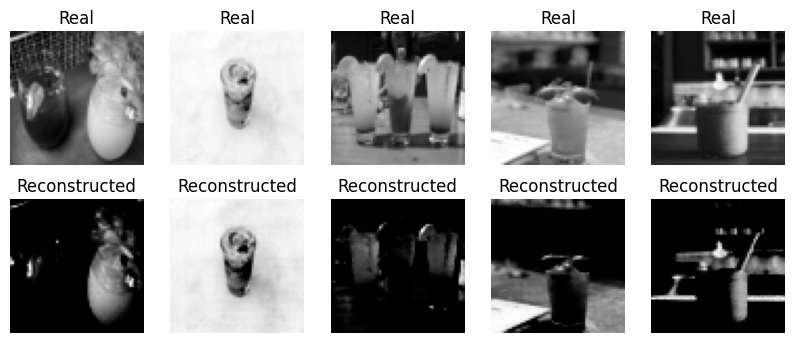

In [472]:
# Visualization
def visualize_images(real_images, reconstructed_images):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(real_images[i].squeeze(), cmap="gray")
        plt.title("Real")
        plt.axis("off")

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

visualize_images(real_images, reconstructed_images)


#### Calculation of Fréchet Inception Distance (FID) and Inception Score (IS)


In [495]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision import transforms
from scipy.linalg import sqrtm
import numpy as np
import matplotlib.pyplot as plt

In [496]:
# Preprocessing pipeline for InceptionV3
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [497]:
def compute_inception_features(images, model, batch_size=32):
    """
    Computes features using the InceptionV3 model.
    Args:
        images (Tensor): Input images (preprocessed).
        model (torch.nn.Module): Pretrained InceptionV3 model.
        batch_size (int): Batch size for feature extraction.
    Returns:
        features (ndarray): Inception features.
    """
    features = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            batch_features = model(batch).cpu().numpy()
            features.append(batch_features)
    return np.concatenate(features, axis=0)


In [498]:
def compute_fid(real_features, fake_features):
    """
    Computes the Frechet Inception Distance (FID).
    Args:
        real_features (ndarray): Features of real images.
        fake_features (ndarray): Features of generated images.
    Returns:
        fid (float): FID score.
    """
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)


In [499]:
def compute_inception_score(preds, splits=10):
    """
    Computes the Inception Score (IS).
    Args:
        preds (ndarray): Softmax predictions from InceptionV3.
        splits (int): Number of splits for IS calculation.
    Returns:
        mean_score (float): Mean IS.
        std_score (float): Standard deviation of IS.
    """
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)


In [500]:
# Load pretrained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove the classification head
inception_model.to(device)
inception_model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [501]:
with torch.no_grad():
    # Preprocess real images
    real_images, _ = next(iter(val_loader)) 
    real_images = real_images[:500]  
    real_images = torch.stack([preprocess(img) for img in real_images]).to(device)

    # Generate fake images
    z = torch.randn(len(real_images), 128).to(device)  
    dummy_encoder_features = [
        torch.zeros((len(real_images), 64, 32, 32)).to(device),
        torch.zeros((len(real_images), 128, 16, 16)).to(device),
        torch.zeros((len(real_images), 256, 8, 8)).to(device),
    ]
    generated_images = vae.decoder(z, dummy_encoder_features).cpu()
    generated_images = torch.stack([preprocess(img) for img in generated_images]).to(device)


In [502]:
# Compute features
real_features = compute_inception_features(real_images, inception_model)
fake_features = compute_inception_features(generated_images, inception_model)

# Compute Inception Score
with torch.no_grad():
    preds = F.softmax(inception_model(generated_images), dim=1).cpu().numpy()
inception_score_mean, inception_score_std = compute_inception_score(preds)

# Compute FID
fid_score = compute_fid(real_features, fake_features)

# Print results
print(f"Inception Score: {inception_score_mean:.2f} ± {inception_score_std:.2f}")
print(f"FID Score: {fid_score:.2f}")


Inception Score: 1.00 ± 0.00
FID Score: 559936185544451052639360570142111069530411374308662383724997275240947967795040236345219373317901778944.00


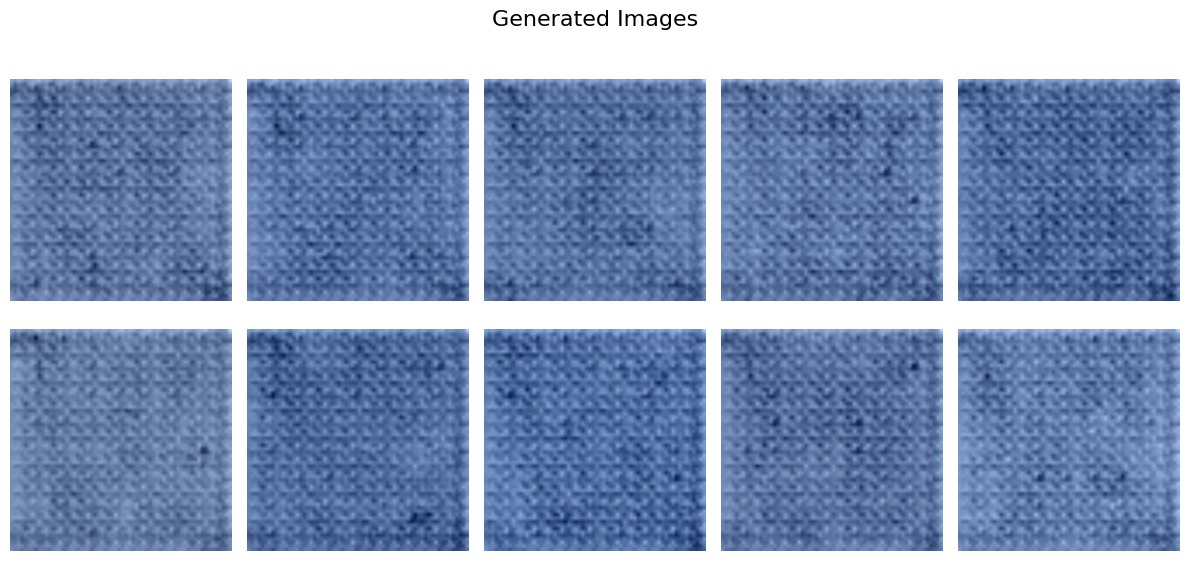

In [494]:
import matplotlib.pyplot as plt

# Visualize generated images
plt.figure(figsize=(12, 6))  
for i in range(10):  
    plt.subplot(2, 5, i + 1)
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()  # Transpose to (H, W, 3)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
    plt.imshow(img)
    plt.axis("off")

# Set the title for the entire figure
plt.suptitle("Generated Images", fontsize=16)
plt.tight_layout()
plt.show()


For this model, we have used encoder features for reconstruction, so it reconstruct good image but for the random image generation it failes, we tried to tune the latent space but not tuned properly.